# DL Lab 3.2 - Homework - Word Embeddings

Welcome to the DL Lab! In this lab, you will train a **word embedding** from scratch and investigate its interesting properties.

In detail, you will train an embedding on a small dataset for sentiment classification on movie reviews, play with it, and create a projected visualization of the embedding space. 

***

**After completing this homework you will be able to**

- Use **Tokenizers** for **word vectorization**.
- Train models containing **word embeddings**.
- Compute **word similarities** and retrieve similar and analogous words.

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=102963) in Moodle.

Let's get started!

# 0 - Test for GPU
Execute the code below for printing the TF version and testing for GPU availability.

In [ ]:
#@title Print TF version and GPU stats
import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.3.0
Found GPU at: /device:GPU:0

Wed Dec 16 17:25:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    76W / 149W |    134MiB / 11441MiB |     11%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Representing Text as Numbers

## 1.1 - One-Hot Encodings

Categorical inputs to a neural network can be represented using **One-Hot Encodings**. We already used them (quite often actually) for class labels.

E.g., consider we are classifying `['bird', 'cat', 'dog', 'fish']` animals with a neural network. The one-hot encoded label of class `'cat'` will look like `[0,1,0,0]`.

We might generalize this idea for creating text representations: We create a **vocabulary** of all unique words of a text. For each word, we will then create a zero vector with length equal to the vocabulary size and place a `1` in the index corresponding to the word in the vocabulary.

There are several problems with this approach: It is extremely inefficient since the one-hot encoded vectors are sparse. As the vocabulary size grows large, most of the space is wasted just for storing zeros. 
In addition, one-hot vectors do not allow computation of similarity measures, as all words will have the same distance to each other.

## 1.2 - Index Encodings

Another approach might be to encode each word using a unique number, e.g., the **index** of the word within the **vocabulary**. This approach would be more efficient compared to sparse one-hot encoded vectors.

However, as the integer-encoding is arbitrary, there is no sorting or ordering. There is still no way to represent that cats might be more similar to dogs than to fish. As there is no relationship between the similarity of any two words and the similarity of their encodings, this also confuses the neural network which might not be able to learn anything meaningful from such encodings.

## 1.3 - Word Embeddings

Word embeddings give us a way to use an efficient, **dense representation** in which **similar words** have a **similar encoding**. Importantly, we do not have to specify this encoding by hand! 

An embedding is a dense vector of floating point values. The length of the vector is a parameter you specify. The values of the embedding are trainable parameters, i.e., weights learned by the model during training. It is common to see word embeddings that are 8-dimensional for small datasets, up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but requires more data to learn.

An intuitive way to think of an embedding is as lookup table. After the embeddings weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

---

# 2 - Using the Embedding layer

So much for the motivation. Let's get started and use embeddings!

Keras makes it easy to use word embeddings by means of its [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The first argument `input_dim` specifies the size of the vocabulary. The second argument `output_dim` is the dimensionality of the embeddings, hence the length of the dense vectors. The `output_dim` is a parameter you can tune and experiment with in the same way you would experiment with the number of neurons in a dense layer.

**Task**: Initialize a layer for embedding words of a vocabulary of 1000 words into 5 dimensions.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
### START YOUR CODE HERE ###  (≈1 LOC)
embedding_layer = layers.Embedding(1000,5)
### END YOUR CODE HERE ###

When you create an `Embedding` layer, the weights for the embedding are randomly initialized just as for any other layer. During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words as learned for the specific problem your model was trained on.

The `Embedding` layer can be understood as a lookup table that maps from integer indices (denoting specific words) to dense vectors (their embeddings). Hence, passing a list of integers to an embedding layer, the result replaces each integer with its corresponding vector from the embedding table:

In [ ]:
result = embedding_layer( np.array([3, 1, 4]) )
print(result.numpy())

[[ 0.02208264  0.01942709  0.04027826 -0.00572944  0.03155648]
 [ 0.03049347 -0.00843795  0.00522105 -0.02951161  0.03331155]
 [-0.03370769 -0.00104406  0.00360634 -0.02160817  0.01879874]]


For text or sequence problems, the `Embedding` layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (a batch of 32 sequences of length 10), or `(64, 15)` (batch of 64 sequences of length 15):

**Task**: Create an input array of shape `(64, 15)` filled with `0` of type `int`, feed it to the `Embedding` layer and print the shape of the result.

In [ ]:
### START YOUR CODE HERE ###  (≈3 LOC)
arr = np.zeros((64,14), dtype=np.int)
result = embedding_layer(arr)
print(result.numpy())

### END YOUR CODE HERE ###

[[[-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  ...
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]]

 [[-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  ...
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]]

 [[-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  [-0.0310155  -0.0426484   0.04302492  0.04389408  0.0055267 ]
  ...
  [-0.0310155  -0.

The returned tensor has one more axis than the input and the embedding vectors are aligned along the new last axis. Hence, the shape of the embedded tensor is `(samples, sequence_length, embedding_size)`.

# 3 - Training Embeddings from Scratch


## 3.1 - Next Word Prediction
You can actually train word embeddings in a model for solving a certain task, just as next word prediction. For this task, you will use the same text data as for the DL Lab 3.1, i.e., a collection of certain tweets.

Execute the cell below for downloading and preprocessing the text data.

In [ ]:
#@title Dataset Download and Preprocessing

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    
dataset_file = '/tmp/tweets.csv'
download_file_from_google_drive('1HE_ezCVWG7JSy5fDSASAmrkmUUbPpWAC', dataset_file)


import pandas as pd

tweets = pd.read_csv(dataset_file, )
tweets.head()

print('Initial amount of Tweets:',len(tweets))
# remove retweets
tweets.drop(tweets[tweets.isRetweet == 't'].index, inplace=True)
# remove unpopular tweets
tweets.drop(tweets[tweets.favorites < 1e4].index, inplace=True)
# convert to lowercase
tweets.text = tweets.text.str.lower()
# remove urls from tweets
tweets.text.replace(regex=r'https?:\/\/(www\.)?[-a-z0-9@:%._\+~#=]{1,256}\.[a-z0-9()]{1,6}\b([-a-z0-9()@:%_\+.~#?&\/=]*)', value='', inplace=True)

# remove hashtags and replace ampersands
tweets.text.replace(regex=r'#\w+', value='', inplace=True)
tweets.text.replace('&amp;', '&', inplace=True, regex=True)

# remove citation tweets
tweets.drop(tweets[tweets.text.str.startswith('"""')].index, inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('"via ')].index, inplace=True)
# remove non alphanumeric chars
tweets.text.replace(regex=r'[^a-z0-9,. ]', value='', inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('    ')].index, inplace=True)
# remove short tweets
tweets.drop(tweets[tweets.text.map(len) < 50].index, inplace=True)
print('Remaining Tweets:',len(tweets))

tweets = tweets.text.to_list()

Initial amount of Tweets: 55090
Remaining Tweets: 14113


In [ ]:
# no. of unique words
len(list(set(' '.join(tweets).split(' '))))

26673

You can see that this dataset has more than 26k different words. However, we will use a vocabulary of 10k most frequent words as detailed in the video.

TensorFlow Keras provides a convenient class for converting text from words into indexed representations: the [Tokenizer class](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer?hl=en).

**Task**: (1) Initialize an instance `tokenizer` of the Tokenizer class using
- a vocabulary size of 10`000 words
- `<unk>` as replacement for any word not contained within the vocabulary,
- a filter for removing special characters '!"“#$%&()*+.,-/:;=?@[\]^_`{|}~ \'.

(2) Next, compute the most 10k frequent words by calling the [`fit_on_texts` method](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer?hl=en#fit_on_texts) on the tweets.

In [ ]:
VOCABULARY_SIZE = int(1e4)

### START YOUR CODE HERE ###  (≈2 LOC)
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words = 1000,
    oov_token = "<unk>",
    filters = '!"“#$%&()*+.,-/:;=?@[]^_`{|}~ '
)
tokenizer.fit_on_texts(tweets)

### END YOUR CODE HERE ###

We also add another token `<pad>` that will be used for padding all sequences to equal length.

In [ ]:
# add `'<pad>'` token to tokenizer at index `0`
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# print first 10 words
print(list(tokenizer.index_word.items())[:10])

[(1, '<unk>'), (2, 'the'), (3, 'to'), (4, 'and'), (5, 'of'), (6, 'a'), (7, 'in'), (8, 'is'), (9, 'for'), (10, 'i')]


The [`text_to_sequences` method](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer?hl=en#texts_to_sequences) of your tokenizer can now be used for converting the text data into index representation.

**Task**: Convert the tweets into index representation and pad the sequences by adding `0`s at the end of every sequence.

In [ ]:
### START YOUR CODE HERE ###  (≈2 LOC)
sequences = tokenizer.texts_to_sequences(tweets)
sequences=tf.keras.preprocessing.sequence.pad_sequences(sequences=sequences,padding='post')

### END YOUR CODE HERE ###

In [ ]:
sequence_length = sequences.shape[1]  
print('Max sequence length:', sequence_length)

Max sequence length: 61


Next, we initialize the dataset, split each tweet into an input and an output sequence, and create shuffled batches:

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EMBEDDING_DIM = 16

def split_input_target(sequence):
  input_sequence = sequence[:-1]
  target_sequence = sequence[1:]
  return input_sequence, target_sequence

dataset = tf.data.Dataset.from_tensor_slices(sequences)
dataset = dataset.map(split_input_target)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 60), (64, 60)), types: (tf.int32, tf.int32)>


We will use a RNN with GRU layer for next word prediction. The next cells build the model and train it for 50 epochs.

If you are interested, increase the size of the GRU layer, e.g., to 1024, and train it for 200 epochs with an early stopping callback.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_gru(vocabulary_size, embedding_dim, batch_size, sequence_length, summary=True):
  
  inputs = layers.Input(batch_input_shape=(batch_size,))
  
  x = layers.Embedding(vocabulary_size,
                       embedding_dim, m)(inputs)
  x = layers.GRU(128,
                 return_sequences=True,
                 stateful=True,
                 )(x)
  x = layers.Dropout(.2)(x)
  out = layers.Dense(vocabulary_size, 
                     activation='softmax'
                     )(x)

  model = Model(inputs, out, name='next_character_prediction')
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                         patience=5, 
                                                         restore_best_weights=True)

In [ ]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'])
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  #ax2.legend()
  plt.show() 

Model: "next_character_prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 60)]                0         
_________________________________________________________________
embedding_1 (Embedding)      (64, 60, 16)              160000    
_________________________________________________________________
gru (GRU)                    (64, 60, 128)             56064     
_________________________________________________________________
dropout (Dropout)            (64, 60, 128)             0         
_________________________________________________________________
dense (Dense)                (64, 60, 10000)           1290000   
Total params: 1,506,064
Trainable params: 1,506,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
220/220 [==============================] - 29s 130ms/step - loss: 3.9254 - accura

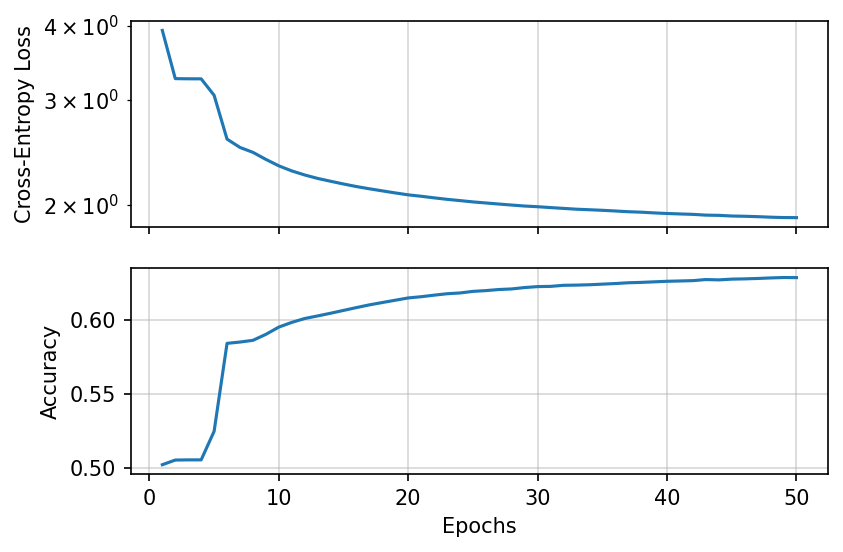

In [ ]:
gru_model = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, BATCH_SIZE, sequence_length)
gru_history = gru_model.fit(dataset, 
                            epochs=50,
                            callbacks=[EarlyStoppingCallback]
                            )
plot_history(gru_history)

# 4 - Operations on Embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding_size)`:

In [ ]:
emb_matrix = gru_model.layers[1].get_weights()[0]
print(emb_matrix.shape)

(10000, 16)


Using the word indices as defined by the tokenizer, you can now retrieve the word embedding vectors from the embedding matrix.

**Task**: Complete the function `get_embedding_vector` for returning the embedding vector of a given word `word_in`.

In [ ]:
def get_embedding_vector( word_in, tokenizer, embedding_matrix ):
  
  assert word_in in tokenizer.word_index.keys(), 'word not in vocabulary: "{}"'.format(word_in)

  ### START YOUR CODE HERE ###  (≈2 LOC)

  # Get the word index
  ind = tokenizer.word_index[word_in]
  # Lookup the embedding vector
  emb_vec = emb_matrix[ind]

  
  ### END YOUR CODE HERE ###

  return emb_vec

In [ ]:
len(list(tokenizer.index_word.keys()))

16286

In [ ]:
get_embedding_vector('dog', tokenizer, emb_matrix)

array([-0.01588162,  0.04801065, -0.00946326,  0.02618463, -0.03257658,
        0.02487237,  0.0173738 , -0.0404321 , -0.03775306,  0.04921504,
       -0.04428474, -0.04773955, -0.03934409, -0.04432237,  0.00366922,
        0.04565248], dtype=float32)

## 4.1 - Word Similarity

To measure how similar two words are, we need a way to measure the degree of similarity between two embeddings vectors for the two words. Given two word vectors $u$ and $v$, cosine similarity is defined by the cosine of the angle $\theta$ between the two vectors: 

$$\text{CosineSimilarity(u, v)} = cos(\theta) = \frac {u \cdot v} {\Vert u \Vert \Vert v \Vert} $$

where $u \cdot v$ is the dot product of two vectors, $\Vert u \Vert$ is the norm (or length) of the vector $u$, and $\theta$ is the angle between $u$ and $v$.

If $u$ and $v$ are very similar, their cosine similarity will be close to 1. If they are dissimilar, the cosine similarity will take a smaller value down to -1. 

**Note**: The norm of $u$ is defined as $ \Vert u \Vert = \sqrt{\sum_{i=1}^{n} u_i^2}$.

**Task**: Complete the function `cosine_similarity`.

In [31]:
def cosine_similarity(u, v):

  ### START YOUR CODE HERE ###  (≈3 LOC) 
  norm_a = np.linalg.norm(u)
  norm_b = np.linalg.norm(v)
  cos_similarity = np.dot(u, v) / (norm_a * norm_b)
  ### END YOUR CODE HERE ###

  return cos_similarity

Let's test some combinations:

In [32]:
print(cosine_similarity(get_embedding_vector( 'beautiful', tokenizer, emb_matrix ),
                        get_embedding_vector( 'wonderful', tokenizer, emb_matrix )))

print(cosine_similarity(get_embedding_vector( 'woman', tokenizer, emb_matrix ),
                        get_embedding_vector( 'man', tokenizer, emb_matrix )))

0.896077
0.12309178


## 4.2 - Similar Word Retrieval

As mentioned in the video, we can use the word embedding for retrieval of $k$ semantically close words:

In [33]:
def closest_word(word_in, emb_matrix, top_k=5):

  # Get embedding vector of input word
  word_in_emb = get_embedding_vector(word_in, tokenizer, emb_matrix)

  # Compute similarities
  similarity = [ cosine_similarity(w_emb, word_in_emb) for w_emb in emb_matrix ]

  # Top-k words having largest similarity
  idxs = np.argsort( similarity )[::-1][1:top_k+1]

  return [ [tokenizer.index_word[i], similarity[i]] for i in idxs ]


for word in ['beautiful', 'news']:
  print(closest_word(word, emb_matrix))

[['important', 0.9083743], ['wonderful', 0.896077], ['every', 0.88394386], ['potential', 0.8737282], ['good', 0.8698812]]
[['credibility', 0.87429506], ['soon', 0.81251645], ['trump', 0.80276686], ['word', 0.7987612], ['happy', 0.78762835]]


## 4.3 - Word Analogy

Another interesting task is the "Word analogy task", where we complete the sentence "`a` is to `b` as `c` is to __". In detail, we are trying to find a word `d`, such that the associated word vectors $e_a$, $e_b$, $e_c$, $e_d$, are related as follows:
$$ e_b - e_a \approx e_d - e_c. $$ 

The similary between $ e_b - e_a $ and $ e_d - e_c $ is measured using cosine similarity.

In [34]:
def complete_analogy(word_a, word_b, word_c):

  # Convert words to lower case
  word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

  # Get the embedding vectors
  e_a = get_embedding_vector(word_a, tokenizer, emb_matrix)
  e_b = get_embedding_vector(word_b, tokenizer, emb_matrix)
  e_c = get_embedding_vector(word_c, tokenizer, emb_matrix)
  
  max_cosine_sim = -100
  best_word = None

  # Loop over the whole word vector set
  for w_idx, w in enumerate(emb_matrix):
    
    # To avoid best_word being one of the input words, pass on them.
    if (w == [e_a, e_b, e_c]).all(1).any():
      continue
    
    # Compute cosine similarity between the vector (e_b - e_a) and the vector (w - e_c)
    ### START YOUR CODE HERE ###  (≈1 LOC)
    cosine_sim = cosine_similarity((e_b - e_a), (w - e_c) )
    ### END YOUR CODE HERE ###

    if cosine_sim > max_cosine_sim:
      # Set new max similarity
      max_cosine_sim = cosine_sim
      # Select new best_word
      best_word_idx = w_idx

      print(cosine_sim, tokenizer.index_word[best_word_idx])
      
  return tokenizer.index_word[best_word_idx]

In [35]:
print(complete_analogy('china', 'beijing', 'usa'))

print(complete_analogy('man', 'king', 'woman'))

0.6917039 <pad>
<pad>
0.47493193 <pad>
0.5253788 prior
0.56955963 broken
0.61883724 popular
0.6264749 fracking
0.6273687 sides
0.6869686 touch
0.71308845 normal
0.75096744 holocaust
0.7884558 balance
balance


You may try different word combinations. However, our word embedding is not very powerful as we used a rather simple model for training, and more importantly, a comparably small text corpus.

## 4.4 - GloVe Embedding

Execute the cell below to download a more powerful word embedding, i.e., a 50-dimensional GloVe word embedding trained on Wikipedia (2014) and the Gigaword 5 corpus. The [GloVe embedding](https://nlp.stanford.edu/projects/glove/) is provided by the NLP research group at Stanford University.

In [ ]:
#@title Download GloVe Embedding

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def unzip(file, destination=None):
  if not destination or not os.path.isdir(destination):
    destination = os.path.dirname(file)
  print('unzipping to ',destination)
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall(destination)
  zip_ref.close()


data_path = '/tmp/glove'
glove_file = os.path.join(data_path, 'glove.6B.50d.txt')
!rm -rf $data_path
os.makedirs(data_path)

# download glove file
download_file_from_google_drive('1JUdsQpf_-fGs8kYA4PBS1rnd0IPZYFVd', glove_file)

def read_glove_vecs(glove_file):
  with open(glove_file, 'r') as f:
    words = set()
    word_to_vec_map = {}
    
    for line in f:
      line = line.strip().split()
      curr_word = line[0]
      words.add(curr_word)
      word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
          
  return words, word_to_vec_map

In [36]:
words, word_to_vec_map = read_glove_vecs(glove_file)

You can get the embedding vector of a string by a lookup in the `word_to_vec_map`. Let's compute some word similarities using the GloVe embedding:

In [37]:
print(cosine_similarity(word_to_vec_map['beautiful'],
                        word_to_vec_map['wonderful'],))

print(cosine_similarity(word_to_vec_map['dog'],
                        word_to_vec_map['cat'],))

print(cosine_similarity(word_to_vec_map['woman'],
                        word_to_vec_map['man'],))

0.8296378712614463
0.9218005273769252
0.886033771849582


Let's see if the GloVe Embedding allows for better analogies:

In [38]:
def complete_analogy_glove(word_a, word_b, word_c):

  # Convert words to lower case
  word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

  # Get the embedding vectors
  e_a = word_to_vec_map[word_a]
  e_b = word_to_vec_map[word_b]
  e_c = word_to_vec_map[word_c]
  
  words = word_to_vec_map.keys()
  max_cosine_sim = -100
  best_word = None

  # Loop over the whole word vector set
  for w in words:        
    
    # To avoid best_word being one of the input words, pass on them.
    if w in [word_a, word_b, word_c] :
      continue
    
    # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)
    cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
    
    if cosine_sim > max_cosine_sim:
      # Set new max similarity
      max_cosine_sim = cosine_sim
      # Select new best_word
      best_word = w
      
  return best_word

Try out a few! Cool triplets are
- `('king', 'man', 'queen')`
- `('russia', 'russian', 'china')`
- `('india', 'delhi', 'japan')`
- `('man', 'woman', 'boy')`
- `('small', 'smaller', 'big')`

In [39]:
complete_analogy_glove('man', 'woman', 'boy')

'girl'

And for the most similar words:

In [40]:
def closest_word_glove(embedding_vector, remove_words=[], top_k=5):

  # Get vocabulary
  vocabulary = list(word_to_vec_map.keys())
  # To avoid top words being one of the input words, remove them from list
  for w in remove_words:
    vocabulary.remove(w)

  # Compute embeddings of all words
  w_embeddings = np.array([word_to_vec_map[w] for w in vocabulary])

  # Compute similarities
  similarity = [ cosine_similarity(w_emb, embedding_vector) for w_emb in w_embeddings ]

  # Index of max similary
  idxs = np.argsort( similarity )[::-1][:top_k]

  return [ [vocabulary[i], similarity[i]] for i in idxs ]


for word in ['beautiful', 'news']:
  print(closest_word_glove(word_to_vec_map[word], [word]))

[['lovely', 0.921088084676833], ['gorgeous', 0.893486407216522], ['wonderful', 0.8296378712614463], ['charming', 0.8249218663752111], ['beauty', 0.8014683990617305]]
[['press', 0.8883447788255655], ['interview', 0.849574463576904], ['newspaper', 0.8341822594978635], ['newspapers', 0.828009445659333], ['reported', 0.8237055907435875]]


***

# Congratulations!

You may now submit your notebook to moodle:
- Enter your email adress in the cell below.
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.